In [1]:
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from DShap import DShap
from shap_utils import *
import pandas as pd
import math
% matplotlib inline
MEM_DIR = './'

UsageError: Line magic function `%` not found.


# 1. Load Datasets
## Clean Datasets
- [Stroke Dataset](https://www.kaggle.com/datasets/zzettrkalpakbal/full-filled-brain-stroke-dataset) (`brain_stroke.csv`) => binary classification: 4982 datapoints, very clean.
- [Heart Dataset](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease) (`heart_2020_cleaned.csv`) => binary classification: 300k+ datapoints, 17 features, unbalanced (9% vs 91%), very clean.

In [ ]:
df_stroke = pd.read_csv('datasets/brain_stroke.csv')
df_heart = pd.read_csv('datasets/heart_2020_cleaned.csv')
print("df_stroke shape = " + str(df_stroke.shape))
print("df_heart shape = " + str(df_heart.shape))
display(df_stroke)
display(df_heart)

# 2. Preliminary Analysis

## Stroke
Class 0 -> `stroke` = 0
Class 1 -> `stroke` = 1

In [ ]:
stroke_class0_size = np.count_nonzero(df_stroke.stroke == 0)
stroke_class1_size = np.count_nonzero(df_stroke.stroke == 1)
print('Stroke')
print('#class 0  = %d' % stroke_class0_size)
print('#class 1  = %d' % stroke_class1_size)
print('P(class 1) = %f' % (stroke_class1_size / df_stroke.shape[0]))

# Heart
Class 0 -> `HeartDisease` = 'No'
Class 1 -> `HeartDisease` = 'Yes'

In [ ]:
heart_class0_size = np.count_nonzero(df_heart.HeartDisease == 'No')
heart_class1_size = np.count_nonzero(df_heart.HeartDisease == 'Yes')
print('Heart')
print('#class 0  = %d' % heart_class0_size)
print('#class 1  = %d' % heart_class1_size)
print('P(class 1) = %f' % (heart_class1_size / df_heart.shape[0]))

Both clean datasets are highly imbalanced.

For now, let us balance both datasets by eliminating datapoints in dominant class at random.

# 3. Data Transformation

## 3.1 Balancing

In [ ]:
stroke_class0_idxs = df_stroke.index[df_stroke.stroke == 0].to_numpy()
heart_class0_idxs = df_heart.index[df_heart.HeartDisease == 'No'].to_numpy()

np.random.seed(140)
num_stroke_remove = math.floor((stroke_class0_size - stroke_class1_size) / 1.6)
stroke_rand_idxs = np.random.choice(stroke_class0_idxs, size=num_stroke_remove, replace=False)

np.random.seed(97)
num_heart_remove = math.floor((heart_class0_size - heart_class1_size) / 2.2)
heart_rand_idxs = np.random.choice(heart_class0_idxs, size=num_heart_remove, replace=False)

df_stroke_balanced = df_stroke.drop(stroke_rand_idxs)
df_heart_balanced = df_heart.drop(heart_rand_idxs)

In [ ]:
print('P(stroke class 1) = %f' % (np.count_nonzero(df_stroke_balanced.stroke == 1) / df_stroke_balanced.shape[0]))
print(
    'P(heart class 1)  = %f' % (np.count_nonzero(df_heart_balanced.HeartDisease == 'Yes') / df_heart_balanced.shape[0]))

## 3.2 Encoding Features

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer

### Stroke
Encode categorical features: `gender`, `ever_married`, `work_type`, `Residence_type`, `smoking_status`.

In [ ]:
yesno_encoder = OrdinalEncoder(categories=[['No', 'Yes']])

column_trans_stroke = make_column_transformer(
    (OrdinalEncoder(categories=[['Male', 'Female']]), ["gender"]),
    (yesno_encoder, ["ever_married"]),
    (OrdinalEncoder(categories=[["children", "Govt_job", "Neverworked", "Private", "Self-employed"]]), ["work_type"]),
    (OrdinalEncoder(categories=[['Rural', 'Urban']]), ["Residence_type"]),
    (OrdinalEncoder(categories=[['never smoked', 'Unknown', 'formerly smoked', 'smokes']]), ["smoking_status"]),
    remainder='passthrough')

data_stroke_trans = column_trans_stroke.fit_transform(df_stroke_balanced)
print("data_trans_stroke shape = " + str(data_stroke_trans.shape))

Next, shuffle stroke dataset.

In [244]:
np.random.seed(48)
np.random.shuffle(data_stroke_trans)

### Heart
Encode categorical features.


In [245]:
yesno_heart_cols = ["HeartDisease", "Smoking", "AlcoholDrinking", "Stroke", "DiffWalking", "PhysicalActivity", "Asthma",
                    "KidneyDisease", "SkinCancer"]

column_trans_heart = make_column_transformer(
    (OrdinalEncoder(categories=[['No', 'Yes'] for i in range(len(yesno_heart_cols))]), yesno_heart_cols),
    (OrdinalEncoder(categories=[["Male", "Female"]]), ["Sex"]),
    (OrdinalEncoder(categories=[np.unique(df_heart_balanced.AgeCategory)]), ["AgeCategory"]),
    (OneHotEncoder(), ["Race"]),
    (OneHotEncoder(), ["Diabetic"]),
    (OrdinalEncoder(categories=[["Poor", "Fair", "Good", "Very good", "Excellent"]]), ["GenHealth"]),
    remainder='passthrough')

data_heart_trans = column_trans_heart.fit_transform(df_heart_balanced)
print("data_heart_trans shape = " + str(data_heart_trans.shape))

data_heart_trans shape = (199319, 26)


Next, shuffle heart dataset.

In [246]:
np.random.seed(20)
np.random.shuffle(data_heart_trans)

Now, isolate features from explained variable in both datasets.

In [252]:
X_stroke = data_stroke_trans[:, 0:10]
y_stroke = data_stroke_trans[:, 10]

X_heart = data_heart_trans[:, 1:]
y_heart = data_heart_trans[:, 0]

print("\nX_stroke shape = " + str(X_stroke.shape))
print("y_stroke shape = " + str(y_stroke.shape))
print("\nX_heart shape = " + str(X_heart.shape))
print("y_heart shape = " + str(y_heart.shape))


X_stroke shape = (2178, 10)
y_stroke shape = (2178,)

X_heart shape = (199319, 25)
y_heart shape = (199319,)


# 4. Compute DSHAP values

First, set the training set size.

Training set also represent the set of data points for which we will compute DSHAP values.

In [253]:
train_size = 100
test_size = 1400
holdout_size = 400

In [254]:
X_stroke_train, y_stroke_train = X_stroke[:train_size], y_stroke[:train_size]
X_stroke_test, y_stroke_test = X_stroke[train_size:(train_size + test_size)], y_stroke[
                                                                              train_size:(train_size + test_size)]

X_heart_train, y_heart_train = X_heart[:train_size], y_heart[:train_size]
X_heart_test, y_heart_test = X_heart[train_size:(train_size + test_size)], y_heart[train_size:(train_size + test_size)]

print("X_stroke_train shape = " + str(X_stroke_train.shape))
print("y_stroke_train shape = " + str(y_stroke_train.shape))
print("X_stroke_test shape = " + str(X_stroke_test.shape))
print("y_stroke_test shape = " + str(y_stroke_test.shape))

print("\nX_heart_train shape = " + str(X_heart_train.shape))
print("y_heart_train shape = " + str(y_heart_train.shape))
print("X_heart_test shape = " + str(X_heart_test.shape))
print("y_heart_test shape = " + str(y_heart_test.shape))

X_stroke_train shape = (100, 10)
y_stroke_train shape = (100,)
X_stroke_test shape = (1400, 10)
y_stroke_test shape = (1400,)

X_heart_train shape = (100, 25)
y_heart_train shape = (100,)
X_heart_test shape = (1400, 25)
y_heart_test shape = (1400,)


In [277]:
def compute_dshap(X_train, y_train, X_test, y_test, model, problem, metric, overwrite, num_test, directory, seed,
                  save_every=100, err=0.1, tolerance=0.01, g_run=False, loo_run=True):
    if X_train.shape[0] != y_train.shape[0]:
        raise Exception('X_train and y_train should have equal length on axis 0.')
    if X_test.shape[0] != y_test.shape[0]:
        raise Exception('X_test and y_test should have equal length on axis 0.')

    if num_test < 0 or num_test >= X_test.shape[0]:
        raise Exception(
            'num_test should be greater than 0 and less than the number of test datapoints (length of X_test on axis 0).')

    X_train = np.array(X_train).astype(float)
    y_train = np.array(y_train).astype(int)
    X_test = np.array(X_test).astype(float)
    y_test = np.array(y_test).astype(int)

    dshap = DShap(X_train, y_train, X_test, y_test, num_test, sources=None, sample_weight=None, model_family=model,
                  metric=metric, overwrite=True, directory=directory, seed=seed)

    dshap.run(save_every=save_every, err=err, tolerance=tolerance, g_run=g_run, loo_run=loo_run)

    dshap.merge_results()

    return dshap

## DSHAP for stroke dataset

In [284]:
dshap = compute_dshap(X_stroke_train, y_stroke_train, X_stroke_test, y_stroke_test, model='logistic',
                      problem='classification', metric='accuracy',
                      overwrite=False, num_test=test_size - holdout_size, directory='./temp_stroke_logistic', seed=7,
                      save_every=100, err=0.1,
                      tolerance=0.01, g_run=False, loo_run=True)

Starting LOO score calculations!
LOO values calculated!
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iter

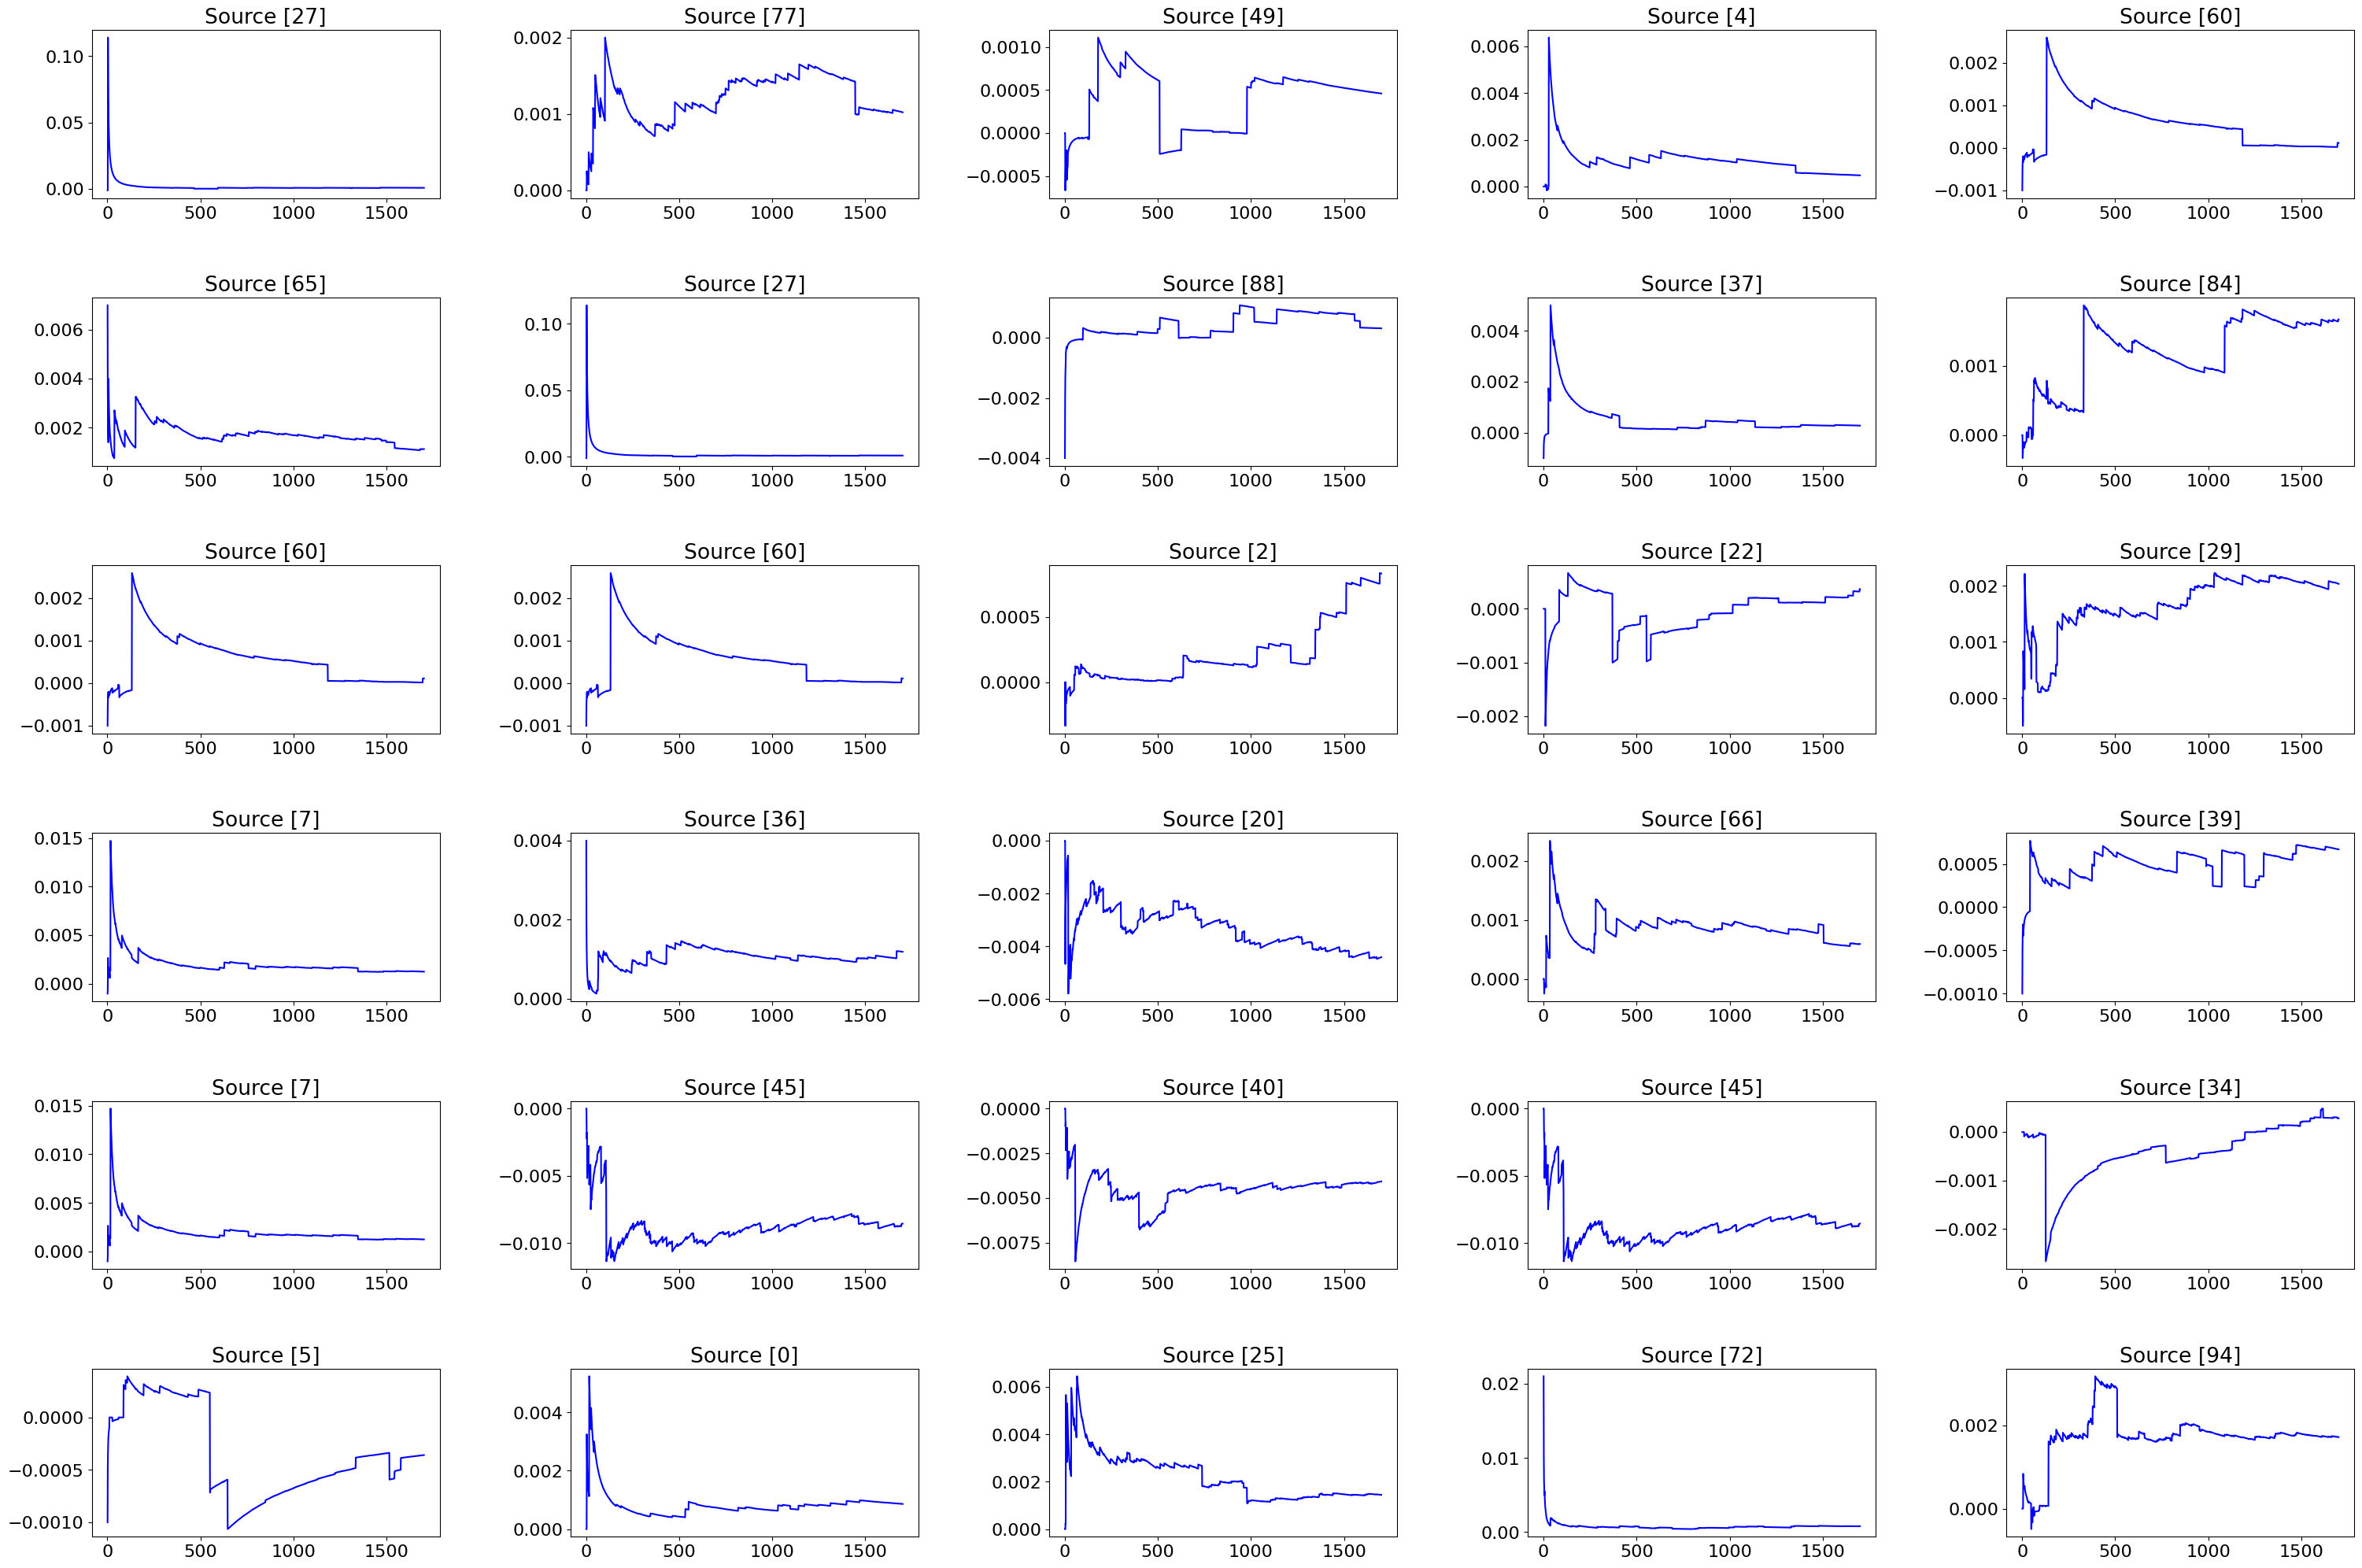

In [285]:
%matplotlib inline
dshap.convergence_plots(source_indexes=np.random.randint(low=0, high=train_size - 1, size=(30, 1)), figsize=(30, 20),
                        h_pad=4, w_pad=4, plot_more_than_25=True)

Let us remove $50\%$ of the top valued sources in the stroke dataset.

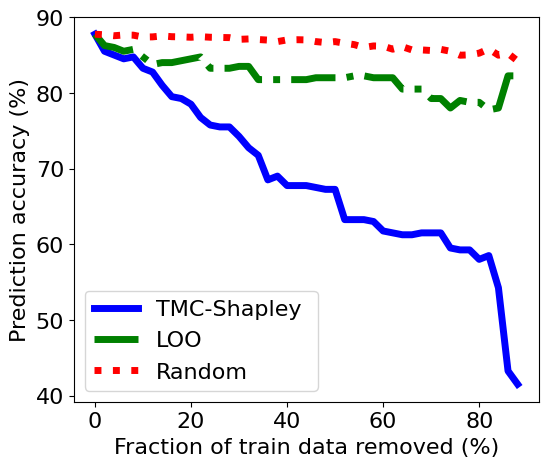

In [286]:
%matplotlib inline
dshap.performance_plots([dshap.vals_tmc, dshap.vals_loo], num_plot_markers=train_size//2,
                        sources=None, figsize=(6, 5), fontsize=16)

## DSHAP for heart dataset

In [287]:
dshap_heart = compute_dshap(X_heart_train, y_heart_train, X_heart_test, y_heart_test, model='logistic',
                      problem='classification', metric='accuracy',
                      overwrite=False, num_test=test_size - holdout_size, directory='./temp_heart_logistic', seed=208,
                      save_every=100, err=0.1,
                      tolerance=0.01, g_run=False, loo_run=True)

Starting LOO score calculations!
LOO values calculated!
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iterations.
60 out of 100 TMC_Shapley iterations.
70 out of 100 TMC_Shapley iterations.
80 out of 100 TMC_Shapley iterations.
90 out of 100 TMC_Shapley iterations.
100 out of 100 TMC_Shapley iterations.
10 out of 100 TMC_Shapley iterations.
20 out of 100 TMC_Shapley iterations.
30 out of 100 TMC_Shapley iterations.
40 out of 100 TMC_Shapley iterations.
50 out of 100 TMC_Shapley iter

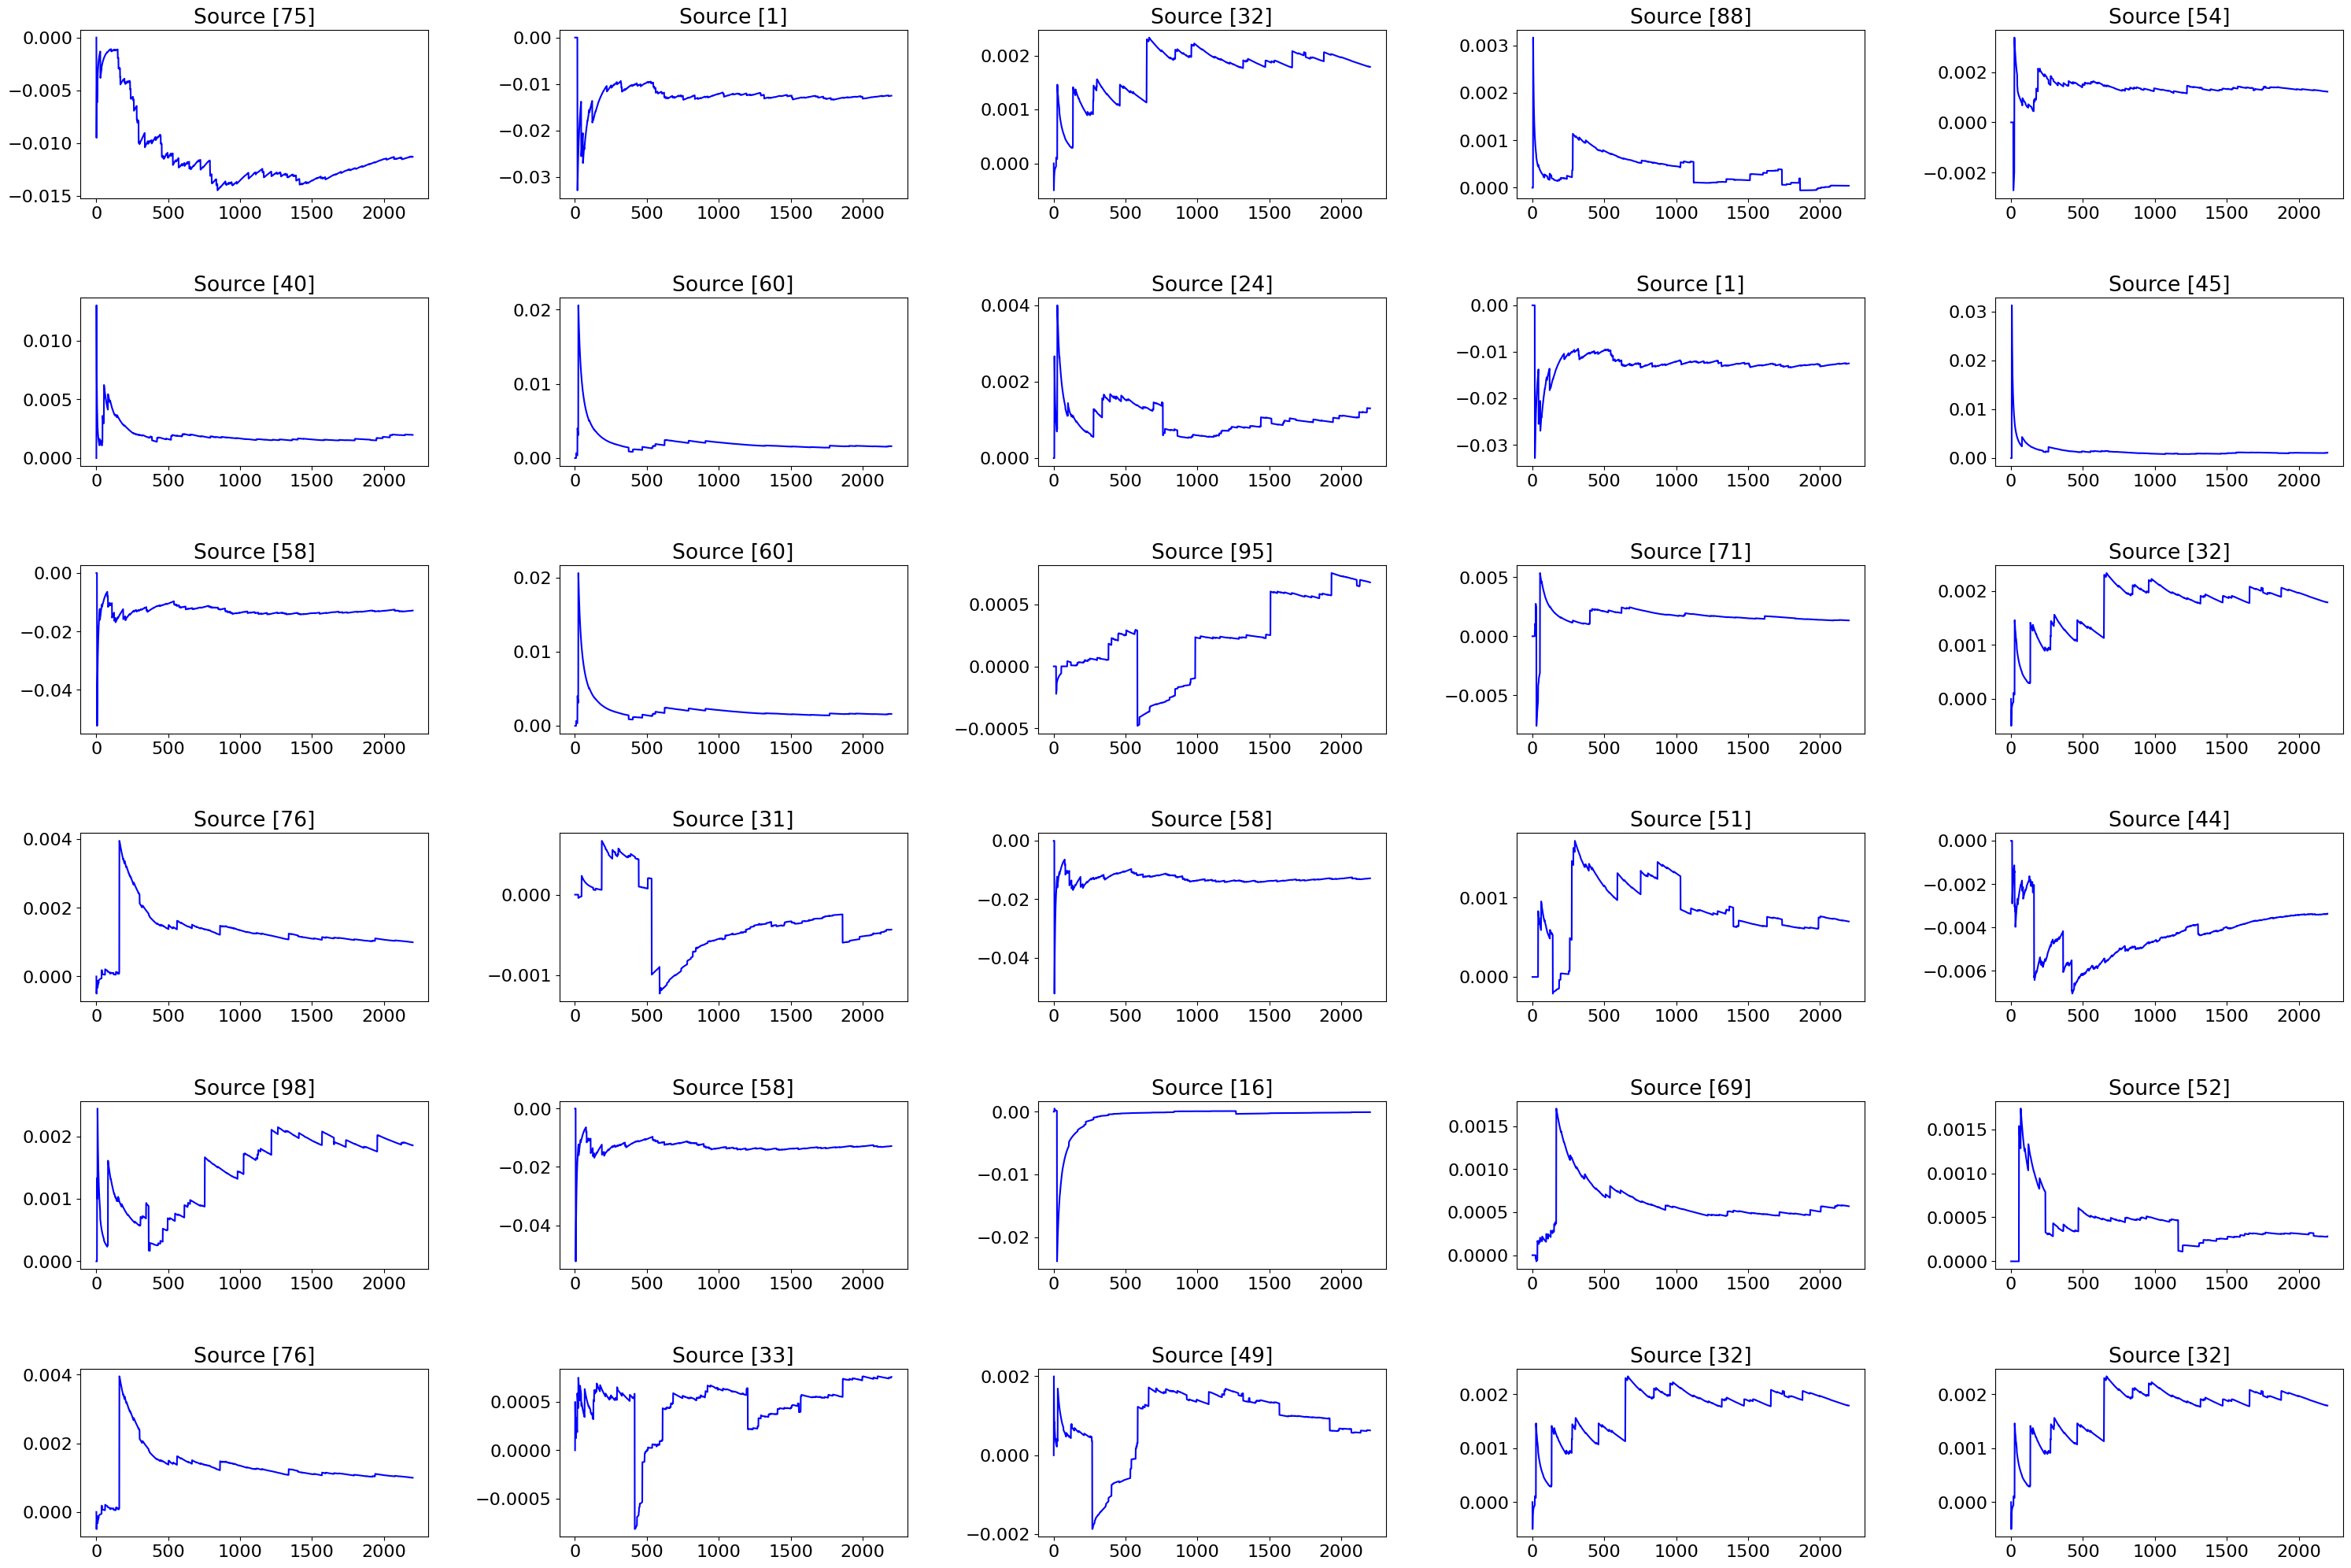

In [288]:
%matplotlib inline
dshap_heart.convergence_plots(source_indexes=np.random.randint(low=0, high=train_size - 1, size=(30, 1)), figsize=(30, 20),
                        h_pad=4, w_pad=4, plot_more_than_25=True)

Let us remove $50\%$ of the top valued sources in the heart dataset.

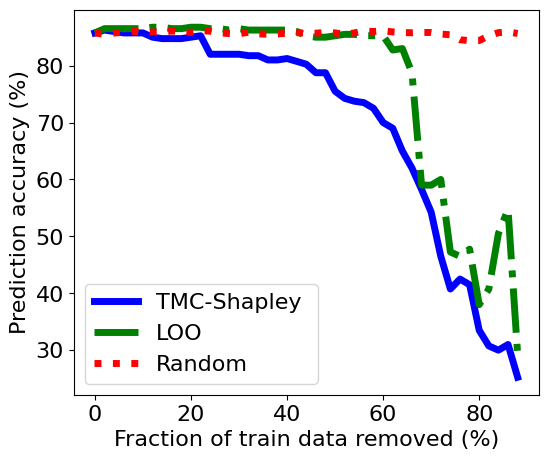

In [289]:
%matplotlib inline
dshap_heart.performance_plots([dshap_heart.vals_tmc, dshap_heart.vals_loo], num_plot_markers=train_size//2,
                        sources=None, figsize=(6, 5), fontsize=16)